In [1]:
import scanpy as sc
from lightning.pytorch import Trainer, seed_everything

from scprint import scPrint
from scprint.tasks import Embedder

from scdataloader import Preprocessor
from scdataloader.utils import load_genes, translate

import numpy as np
import pandas as pd

from scib_metrics.benchmark import Benchmarker

import matplotlib.pyplot as plt

from collections import Counter

%load_ext autoreload
%autoreload 2

import torch
torch.set_float32_matmul_precision('medium')


💡 loaded instance: jkobject/scprint


## preparing the model

In [3]:
#model = scPrint.load_from_checkpoint('../../data/tensorboard/scprint_test/urxxwu28/checkpoints/epoch=0-step=20000.ckpt') #chocolate-surf-8
model = scPrint.load_from_checkpoint('../../data/temp/pk2sldhk/epoch=6-step=35000.ckpt', precpt_gene_emb = '../../data/temp/embeddings.parquet')
# ../../data/temp/epoch=4-step=12500.ckpt latest model maestro (fortuitous laugther)
# ../../data/logs/scprint_test/f4vao230/checkpoints/epoch=10-step=27500.ckpt looked good as a training run (vermlillion noodle)
# d1792z9k/epoch=3-step=10000.ckpt
# '../../data/temp/d1792z9k/epoch=3-step=10000.ckpt'
# '../../data/temp/6q3dzi3x/epoch=3-step=10000.ckpt'
# '../../data/temp/grsachbg/epoch=2-step=15000.ckpt'
## post debug
# "../lightning_logs/version_14/checkpoints/epoch=1-step=5000.ckpt"

/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/lightning/pytorch/utilities/migration/utils.py:55: PossibleUserWarning: The loaded checkpoint was produced with Lightning v2.2.0.post0, which is newer than your current Lightning version: v2.0.9.post0
  rank_zero_warn(


ValueError: Unknown arch_style: None

## Loading the data

In [ ]:
#only dataset dropped
adata = sc.read_h5ad('/home/ml4ig1/scprint/.lamindb/z7ZZxORUQFshySbuvNW7.h5ad') 

# one that it trained on: z7ZZxORUQFshySbuvNW7.
# untrained on: BljRloq1xjcxRNDpejzI

In [3]:
adata = sc.read(
    "data/pancreas_atlas.h5ad",
    backup_url="https://figshare.com/ndownloader/files/24539828",
)


/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


In [ ]:
adata = sc.read(
    "data/lung_atlas.h5ad",
    backup_url="https://figshare.com/ndownloader/files/24539942",
)

/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


In [4]:
preprocessor = Preprocessor(subset_hvg=1000, use_layer='counts', is_symbol=True, force_preprocess=True, skip_validate=True, do_postp=False)

In [5]:
adata.obs['organism_ontology_term_id'] = "NCBITaxon:9606"
adata = preprocessor(adata.copy())

Data is not raw counts, please check layers, find raw data, or bypass with force_preprocess
Removed 0 genes.
Seeing 4678 outliers (28.56% of total dataset):


/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:61: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(


In [33]:
adata

View of AnnData object with n_obs × n_vars = 16382 × 70116
    obs: 'tech', 'celltype', 'size_factors', 'organism_ontology_term_id', 'nnz', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier'
    var: 'uid', 'symbol', 'stable_id', 'ncbi_gene_ids', 'biotype', 'description', 'synonyms', 'organism_id', 'public_source_id', 'created_at', 'updated_at', 'created_by_id', 'mt', 'ribo', 'hb', 'organism', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'unseen_genes', 'hvg'
    layers: 'clean'

In [ ]:
sc.pl.umap(adata, color=["cell_type", "development_stage", "assay", "disease", "sex", "self_reported_ethnicity"])

In [35]:
Counter(adata.obs.celltype)

Counter({'alpha': 5493,
         'beta': 4169,
         'ductal': 2142,
         'acinar': 1669,
         'delta': 1055,
         'gamma': 699,
         'activated_stellate': 464,
         'endothelial': 313,
         'quiescent_stellate': 193,
         'macrophage': 79,
         'mast': 42,
         'epsilon': 32,
         'schwann': 25,
         't_cell': 7})

# good dataset

In [6]:
subadata = adata[adata.obs.celltype=="gamma"]
subadata

View of AnnData object with n_obs × n_vars = 699 × 70116
    obs: 'tech', 'celltype', 'size_factors', 'organism_ontology_term_id', 'nnz', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier'
    var: 'uid', 'symbol', 'stable_id', 'ncbi_gene_ids', 'biotype', 'description', 'synonyms', 'organism_id', 'public_source_id', 'created_at', 'updated_at', 'created_by_id', 'mt', 'ribo', 'hb', 'organism', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'unseen_genes', 'hvg'
    layers: 'clean'

In [7]:
sc.pp.highly_variable_genes(subadata, n_top_genes=1500, flavor='seurat_v3')
highly_variable = subadata.var.index[subadata.var.highly_variable].tolist()

/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:61: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(
/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:148: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns['hvg'] = {'flavor': 'seurat_v3'}


In [8]:
trainer = Trainer(precision="16-mixed")

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [9]:
from scdataloader.data import SimpleAnnDataset
from scdataloader import Collator
from torch.utils.data import DataLoader

In [10]:
organisms=[
    "NCBITaxon:9606",
]
subadata.obs['organism_ontology_term_id'] = organisms[0]

In [11]:
adataset = SimpleAnnDataset(
    subadata[:64], obs_to_output=["organism_ontology_term_id"]
)
col = Collator(
    organisms=organisms,
    valid_genes=model.genes,
    how="some",
    genelist=highly_variable,
)
dataloader = DataLoader(
    adataset,
    collate_fn=col,
    batch_size=64,
    num_workers=1,
    shuffle=False,
)
model.get_attention_layer=[3]
# self.trainer.num_predict_batches = 1

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, predict_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 40 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting: 0it [00:00, ?it/s]

/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


         Falling back to preprocessing with `sc.pp.pca` and default params.


/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


AnnData object with n_obs × n_vars = 64 × 256
    obs: 'pred_cell_type_ontology_term_id', 'pred_disease_ontology_term_id', 'pred_assay_ontology_term_id', 'pred_self_reported_ethnicity_ontology_term_id', 'pred_sex_ontology_term_id', 'pred_organism_ontology_term_id', 'conv_pred_cell_type_ontology_term_id', 'conv_pred_disease_ontology_term_id', 'conv_pred_assay_ontology_term_id', 'conv_pred_self_reported_ethnicity_ontology_term_id', 'leiden'
    uns: 'neighbors', 'umap', 'leiden'
    obsm: 'X_pca', 'X_umap'
    obsp: 'distances', 'connectivities'


/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(

couldn't log to tensorboard
couldn't log to wandb


[[tensor([[0.1958, 0.2647, 0.2100,  ..., 0.2074, 0.1765, 0.2203],
          [0.4510, 0.7331, 0.5068,  ..., 0.4987, 0.5721, 0.5229],
          [0.2756, 0.4099, 0.3071,  ..., 0.2919, 0.1633, 0.6362],
          ...,
          [0.3628, 0.3950, 0.3556,  ..., 0.3602, 0.2957, 0.3711],
          [0.3455, 0.4246, 0.3442,  ..., 0.3396, 0.2535, 0.3534],
          [0.5210, 0.6644, 0.5533,  ..., 0.5810, 0.5692, 0.5203]]),
  tensor([[1.4247e+03, 2.9339e+01, 1.3384e+03,  ..., 2.2414e+03, 1.8685e+01,
           2.4330e+03],
          [1.4815e+03, 4.8082e+00, 1.6621e+02,  ..., 3.9563e+02, 3.6614e+00,
           3.4105e+02],
          [2.6826e+03, 7.6984e+00, 9.0560e+02,  ..., 1.6398e+03, 2.5586e+00,
           8.2480e+04],
          ...,
          [2.6979e+02, 3.6022e+02, 4.0029e+02,  ..., 1.4699e+03, 5.3333e+01,
           4.3805e+04],
          [4.1536e+01, 1.2041e+01, 4.3621e+02,  ..., 4.3451e+02, 2.9106e+00,
           4.2444e+02],
          [3.4652e+04, 5.9431e+00, 9.7713e+01,  ..., 5.6331e+01, 4.

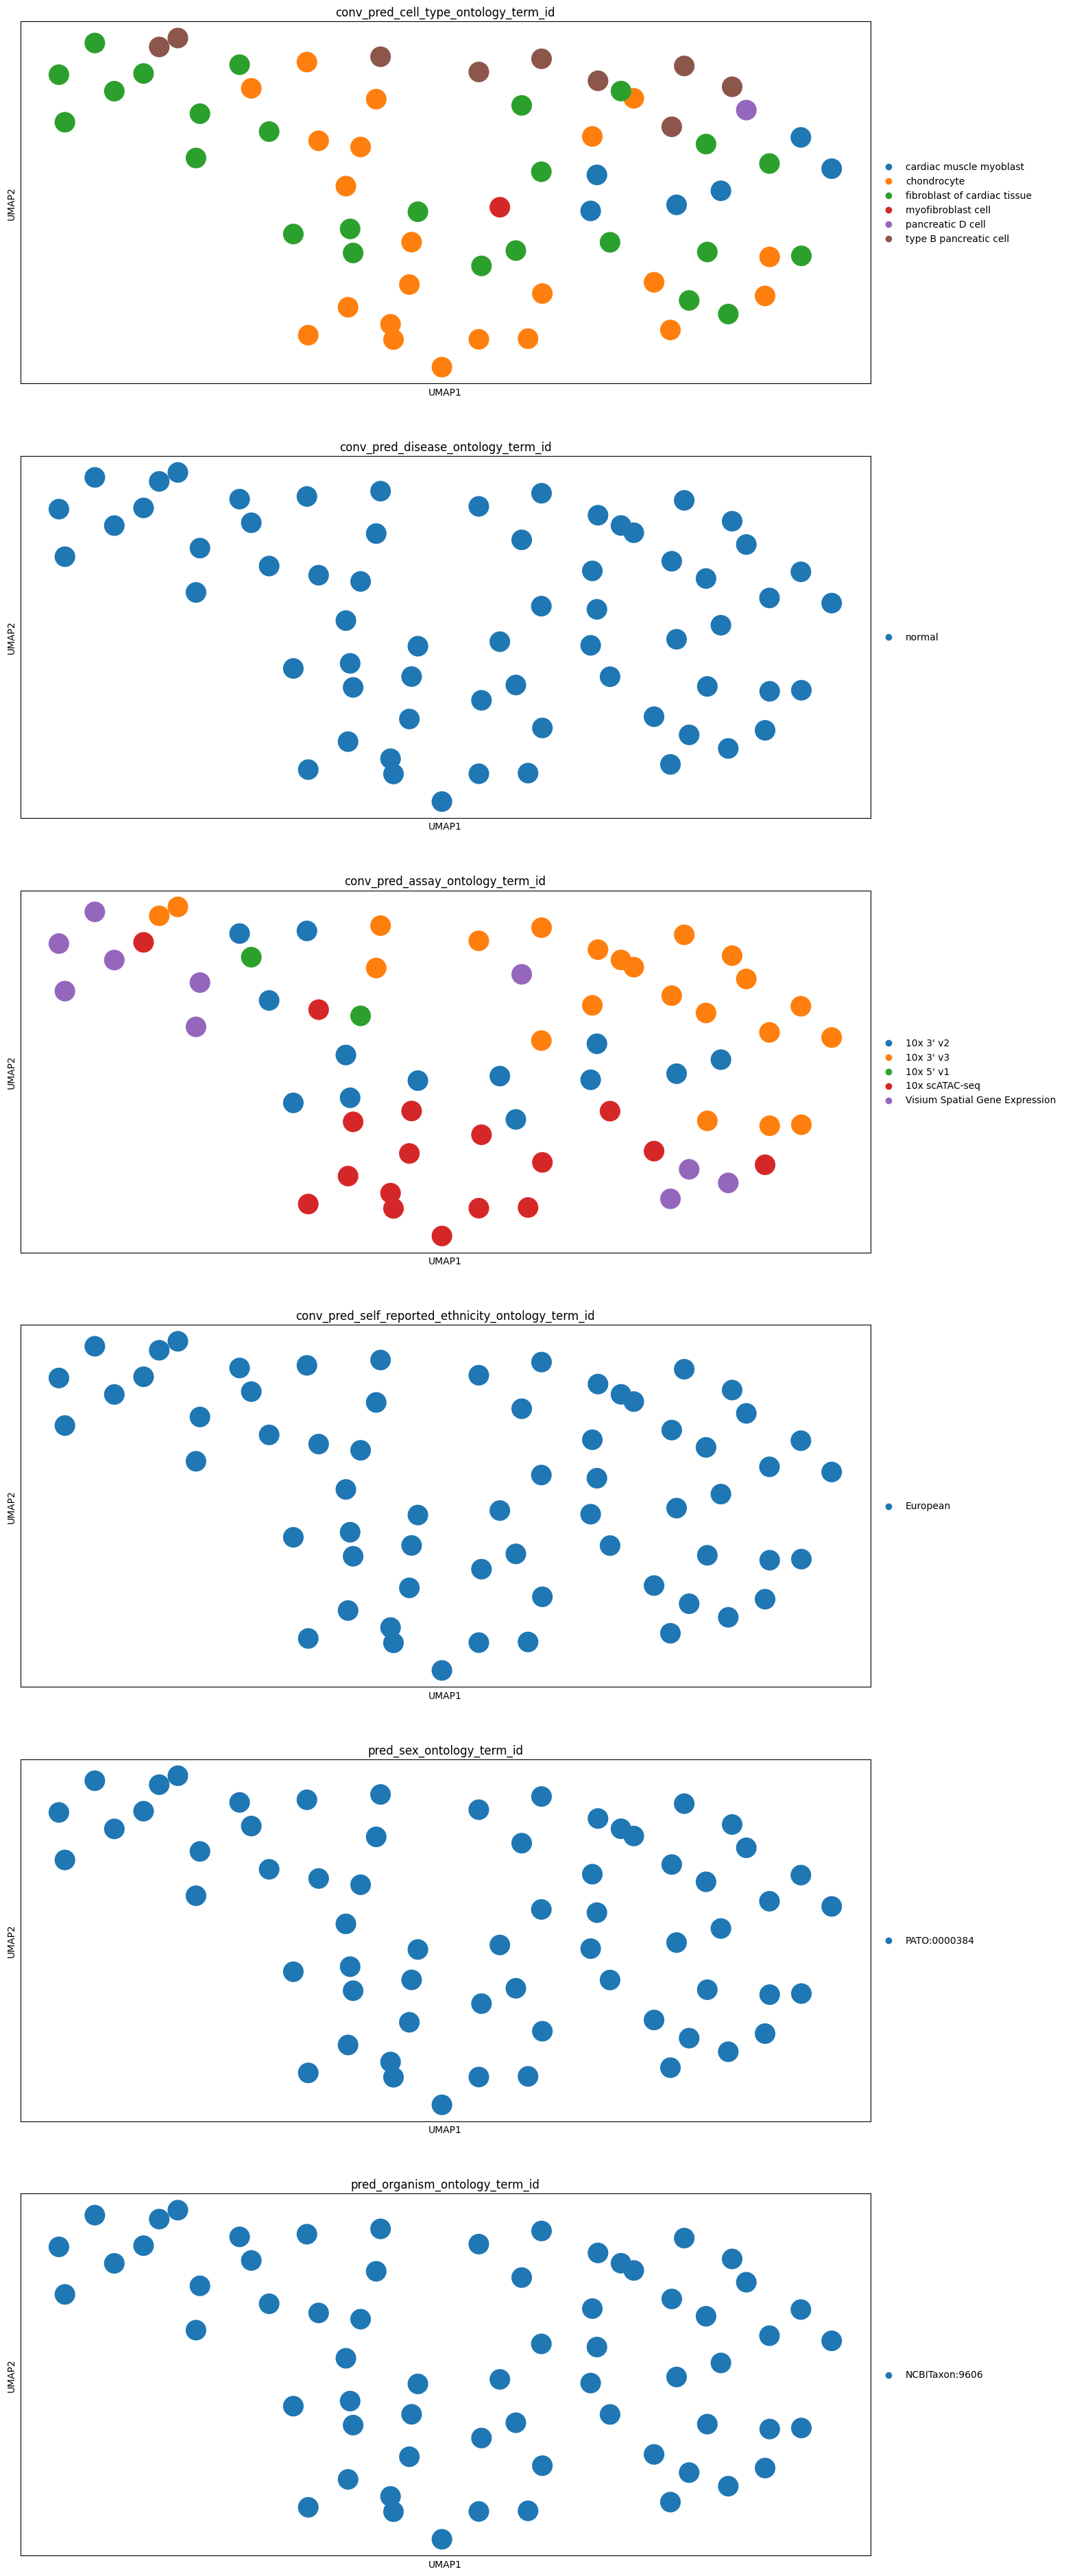

In [12]:
trainer.predict(model, dataloader)

In [61]:
from scprint.utils.sinkhorn import SinkhornDistance

In [112]:
attn = model.mean_attn[:,0,:,:].permute(1,0,2) @ model.mean_attn[:,1,:,:].permute(1,2,0)
scale = model.mean_attn.shape[-1] ** -0.5
attn = attn * scale

sink = SinkhornDistance(0.1, max_iter=200)
a = sink(attn)[0]
a = a * a.shape[-1]

a = a.mean(0).detach().cpu().numpy()
print("avg link count: "+str((a>(3/attn.shape[-1])).sum() / attn.shape[-1]))
a[a.mean(0)<(3/a.shape[-1])] = 0

tensor(56.9960, device='cuda:0')

In [120]:
a.shape

(1497, 1497)

In [126]:
from grnndata import GRNAnnData
from grnndata import utils 

ModuleNotFoundError: No module named 'grnndata'

In [121]:
grn = GRNAnnData(subdata.copy(), grn=a)

NameError: name 'GRNAnnData' is not defined

In [67]:
top_central_genes = utils.get_centrality(grn)
grn.var.loc[[i[0] for i in top_central_genes],'feature_name']

grn.var_names = grn.var['feature_name']
grn.var['TFs'] = [True if i in utils.TF else False for i in grn.var_names]

grn.write('grn.h5ad')

torch.Size([4, 1497, 1497])

In [ ]:
res = utils.enrichment(grn, of='Central')

In [ ]:
utils.enrichment(grn, of='Regulators')

In [ ]:
utils.enrichment(grn, of='Targets')

In [119]:
torch.cuda.empty_cache()